<a href="https://colab.research.google.com/github/VictoriaPedrozaAI/NLP-Projects/blob/main/Fake_News__LR_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
!pip install transformers datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu1

In [44]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification,AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Mount Drive - Fake News


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset from: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data

In [4]:
fake = pd.read_csv('/content/drive/MyDrive/NLP - Project/Task 5/Fake.csv')

In [5]:
true = pd.read_csv('/content/drive/MyDrive/NLP - Project/Task 5/True.csv')

## Pre-processing

### Label fake and true

In [6]:
fake['label'] = 1
true['label'] = 0

### Merge Datasets

In [7]:
df = pd.concat([fake, true], ignore_index=True)

In [8]:
df.head(5)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [9]:
df.shape

(44898, 5)

### Cleaning

In [10]:
df.dropna(subset=['text'], inplace=True)

In [11]:
df.drop_duplicates(subset=['text', 'title'], inplace=True)

In [12]:
df.shape

(39105, 5)

In [13]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()

    cleaned_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words
    ]

    return ' '.join(cleaned_tokens)

df['c_text'] = df['text'].apply(clean_text)
df.head(5)

,title,text,subject,date,label,c_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,donald trump wish american happy new year leav...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,friday revealed former milwaukee sheriff david...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,christmas day donald trump announced would bac...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,pope francis used annual christmas day message...


In [14]:
df = df.drop(columns=['subject','date'])

In [15]:
df.head(5)

,title,text,label,c_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,donald trump wish american happy new year leav...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1,friday revealed former milwaukee sheriff david...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1,christmas day donald trump announced would bac...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,pope francis used annual christmas day message...


### Shuffling

In [16]:
df2 = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
df2.head(5)

,title,text,label,c_text
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,0,washingtonnew york reuters ted wade hasnt care...
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,0,beirut reuters commander iran elite revolution...
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,0,phnom penh reuters cambodian prime minister hu...
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,1,david duke perhaps one notorious grand wizard ...
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,1,hillary clinton show true color finger wagging...


## Training

### Split

In [18]:
X = df2['c_text']
y = df2['label']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31284,), (7821,), (31284,), (7821,))

##  Logistic Regression

In [21]:
# TF -IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [22]:
X_train_t = tfidf_vectorizer.fit_transform(X_train)

In [23]:
X_test_t = tfidf_vectorizer.transform(X_test)

In [45]:
logmodel = LogisticRegression(random_state=42)
logmodel.fit(X_train_t, y_train)

LogisticRegression(random_state=42)

### Test and Metrics

In [29]:
y_pred = logmodel.predict(X_test_t)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100 :.4f}%")
print(f"Precision: {precision * 100 :.4f}%")
print(f"Recall: {recall * 100 :.4f}%")
print(f"F1-score: {f1 * 100 :.4f}%")
print(f"ROC-AUC: {roc_auc*100:.4f}%")

Accuracy: 98.5040%
Precision: 98.6069%
Recall: 98.1420%
F1-score: 98.3739%
ROC-AUC: 98.4779%


In [26]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4215
           1       0.99      0.98      0.98      3606

    accuracy                           0.99      7821
   macro avg       0.99      0.98      0.98      7821
weighted avg       0.99      0.99      0.99      7821



In [46]:
# prediction the test set
y_pred = logmodel.predict(X_test_t)

# predictione positive class label 1
y_pred_proba = logmodel.predict_proba(X_test_t)[:, 1]

In [47]:
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC Score: {roc_auc*100:.4f}%")

ROC-AUC Score: 99.8695%


In [32]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Real News', 'Fake News']))


Classification Report:

              precision    recall  f1-score   support

   Real News       0.98      0.99      0.99      4215
   Fake News       0.99      0.98      0.98      3606

    accuracy                           0.99      7821
   macro avg       0.99      0.98      0.98      7821
weighted avg       0.99      0.99      0.99      7821



### Plots Logistic Regression

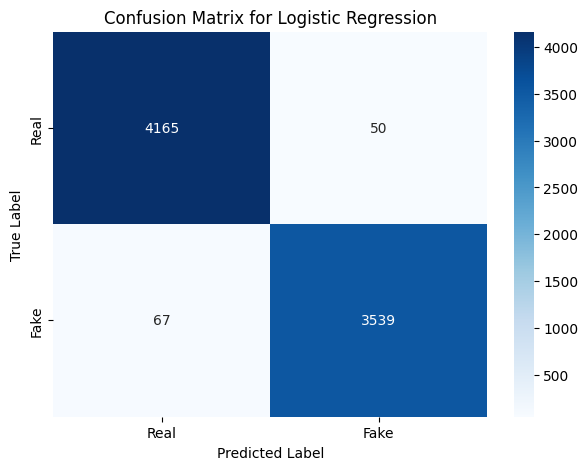

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

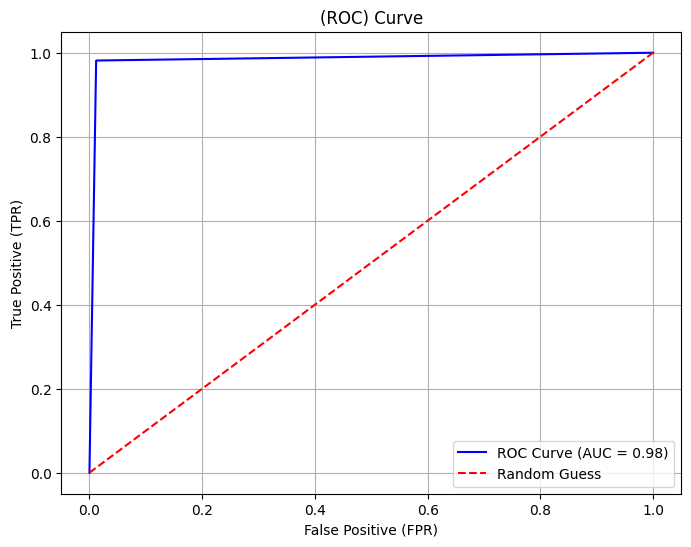

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_score = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive (FPR)')
plt.ylabel('True Positive (TPR)')
plt.title('(ROC) Curve')
plt.legend()
plt.grid()
plt.show()

## DistilBERT

In [48]:
from datasets import Dataset, DatasetDict

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 31284
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 7821
    })
})


In [49]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# tokenize text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(["text", "__index_level_0__"])

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format("torch")

print(tokenized_datasets)

Map:   0%|          | 0/31284 [00:00<?, ? examples/s]

Map:   0%|          | 0/7821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 31284
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 7821
    })
})


In [50]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    probabilities = torch.nn.functional.softmax(torch.from_numpy(logits), dim=-1).numpy()

    return {
        'accuracy_d': accuracy_score(labels, predictions),
        'f1_d': f1_score(labels, predictions),
        'precision_d': precision_score(labels, predictions),
        'recall_d': recall_score(labels, predictions),
        'roc_auc_d': roc_auc_score(labels, probabilities[:, 1])
    }

In [53]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy D,F1 D,Precision D,Recall D,Roc Auc D
1,0.014300,0.006485,0.997826,0.997640,0.998888,0.996395,0.999994
2,0.000400,0.002011,0.999616,0.999584,0.999723,0.999445,0.999999


TrainOutput(global_step=3912, training_loss=0.023871532307817755, metrics={'train_runtime': 3030.8364, 'train_samples_per_second': 20.644, 'train_steps_per_second': 1.291, 'total_flos': 8288220199108608.0, 'train_loss': 0.023871532307817755, 'epoch': 2.0})

In [56]:
metrics = trainer.evaluate()

print("Transformer Model Evaluation:")
print(f"Accuracy: {metrics['eval_accuracy_d'] * 100 :.4f}%")
print(f"Precision: {metrics['eval_precision_d'] * 100 :.4f}%")
print(f"Recall: {metrics['eval_recall_d'] * 100 :.4f}%")
print(f"F1-score: {metrics['eval_f1_d'] * 100 :.4f}%")
print(f"ROC-AUC Score: {metrics['eval_roc_auc_d']*100:.4f}%")

Transformer Model Evaluation:
Accuracy: 99.9616%
Precision: 99.9723%
Recall: 99.9445%
F1-score: 99.9584%
ROC-AUC Score: 99.9999%


In [57]:
predictions = trainer.predict(tokenized_datasets["test"])

In [58]:
y_pred = np.argmax(predictions.predictions, axis=1)
# true labels
y_true = predictions.label_ids

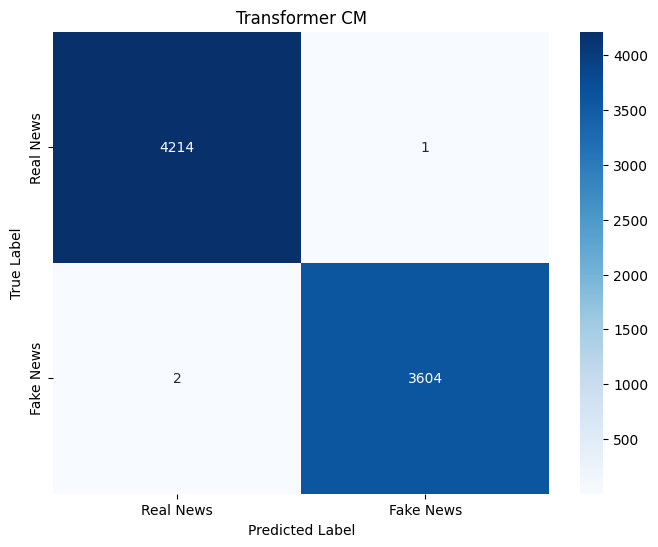

In [67]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real News', 'Fake News'],
            yticklabels=['Real News', 'Fake News'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Transformer CM')
plt.show()

In [65]:
logits = predictions.predictions

probabilities = torch.nn.functional.softmax(torch.from_numpy(logits), dim=-1).numpy()

y_scores = probabilities[:, 1]

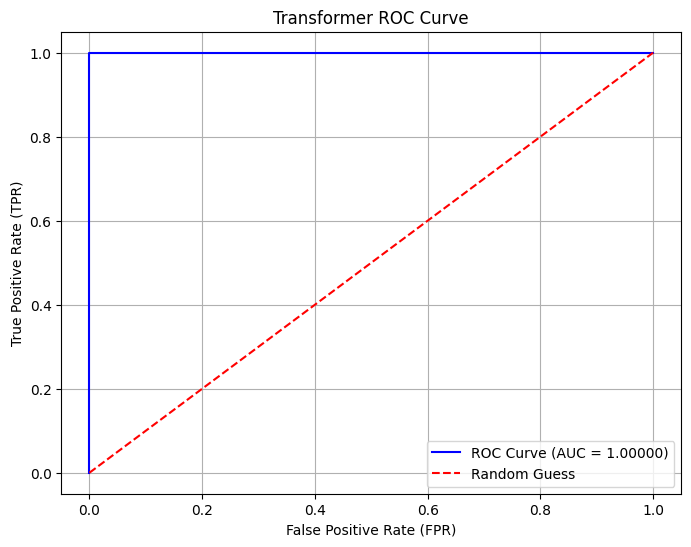

In [66]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.5f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Transformer ROC Curve')
plt.legend()
plt.grid(True)
plt.show()